# Exercise 3

Shape Matching: Represent shapes with a string of equidistance contour points, labeled with their angle (0 if continuing in the same direction, ≠0 for turns

Dynamic time warping aligns two sequences along a common time axis by considering only substitutions $(x_i \rightarrow y_j)$, usually with Euclidean cost: 
$c(x_i \rightarrow y_j)= ||x_i − y_j|| = \sqrt{\sum_{k=1}^{n}(x_{i,k} − y_{j,k})^2}$

## Keyword Spotting: 
Describe words as feature vector sequences with a sliding window.
Retrieve words similar to a query word from the document.

## Our data:  
* /ground-truth/transcription.txt:  Contains the transcription of all words (on a character level) of the whole dataset. 
* /ground-truth/locations/*.svg: Contains bounding boxes for all words in the svg-format.

* /images/*.jpg: original images in jpg-format.

* /task:  Contains three files: ####train.txt / valid.txt #### Contains a splitting of the documents into a training and a validation set. keywords.txt: Contains a list of keywords of which each will be at least once in the training and validation dataset.
## Understanding the data 
The SVG images (in /ground-truth/locations/*.svg) contain the bounding boxes for all words. What one did was creating th polygon "box" aorund the separate words and the idea is that the bounding box can tell us what the word inside it is. Each word in manuscript has a single bounding box. 

In the transcription.txt file you can find which word would be in which bounding box eg. 270-01-03 O-r-d-e-r-s means that in document 270 on line 1 the third word is *Orders*. 


## What to do?
The idea is to get the polygons out of the SVGs (in /ground-truth/locations/*.svg), i.e. cut out those polygons and save them in single files. 

Then, one has to go trough those polygons and find out which polygon is which word (this is known!). Then, re-evaluate on test set. 

## Preliminaries
We start with some imports

In [1]:
from PIL import Image, ImageDraw
from skimage.filters import threshold_otsu, threshold_sauvola  # I am not quite sure yet if otsu is the best binarization
import numpy as np
from IPython.display import display
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import os
import pickle
import matplotlib.pyplot as plt

from keyword_spotting_lib import *

## Preprocessing
First load train images: 

In [2]:
images_path = "images"
imgs = {f: np.array(Image.open(f"images/{f}")) for f in os.listdir(images_path)}

Next use Otsu method to binarize all training images:

In [3]:
def binarize(i, t):
    """Binarize an image (as numpy array) using the given threshold."""

    thresholded_im = np.zeros(i.shape)
    thresholded_im[i >= t] = 1
    return thresholded_im

binarized_imgs = {k: binarize(v, threshold_otsu(v)) for (k, v) in imgs.items()}

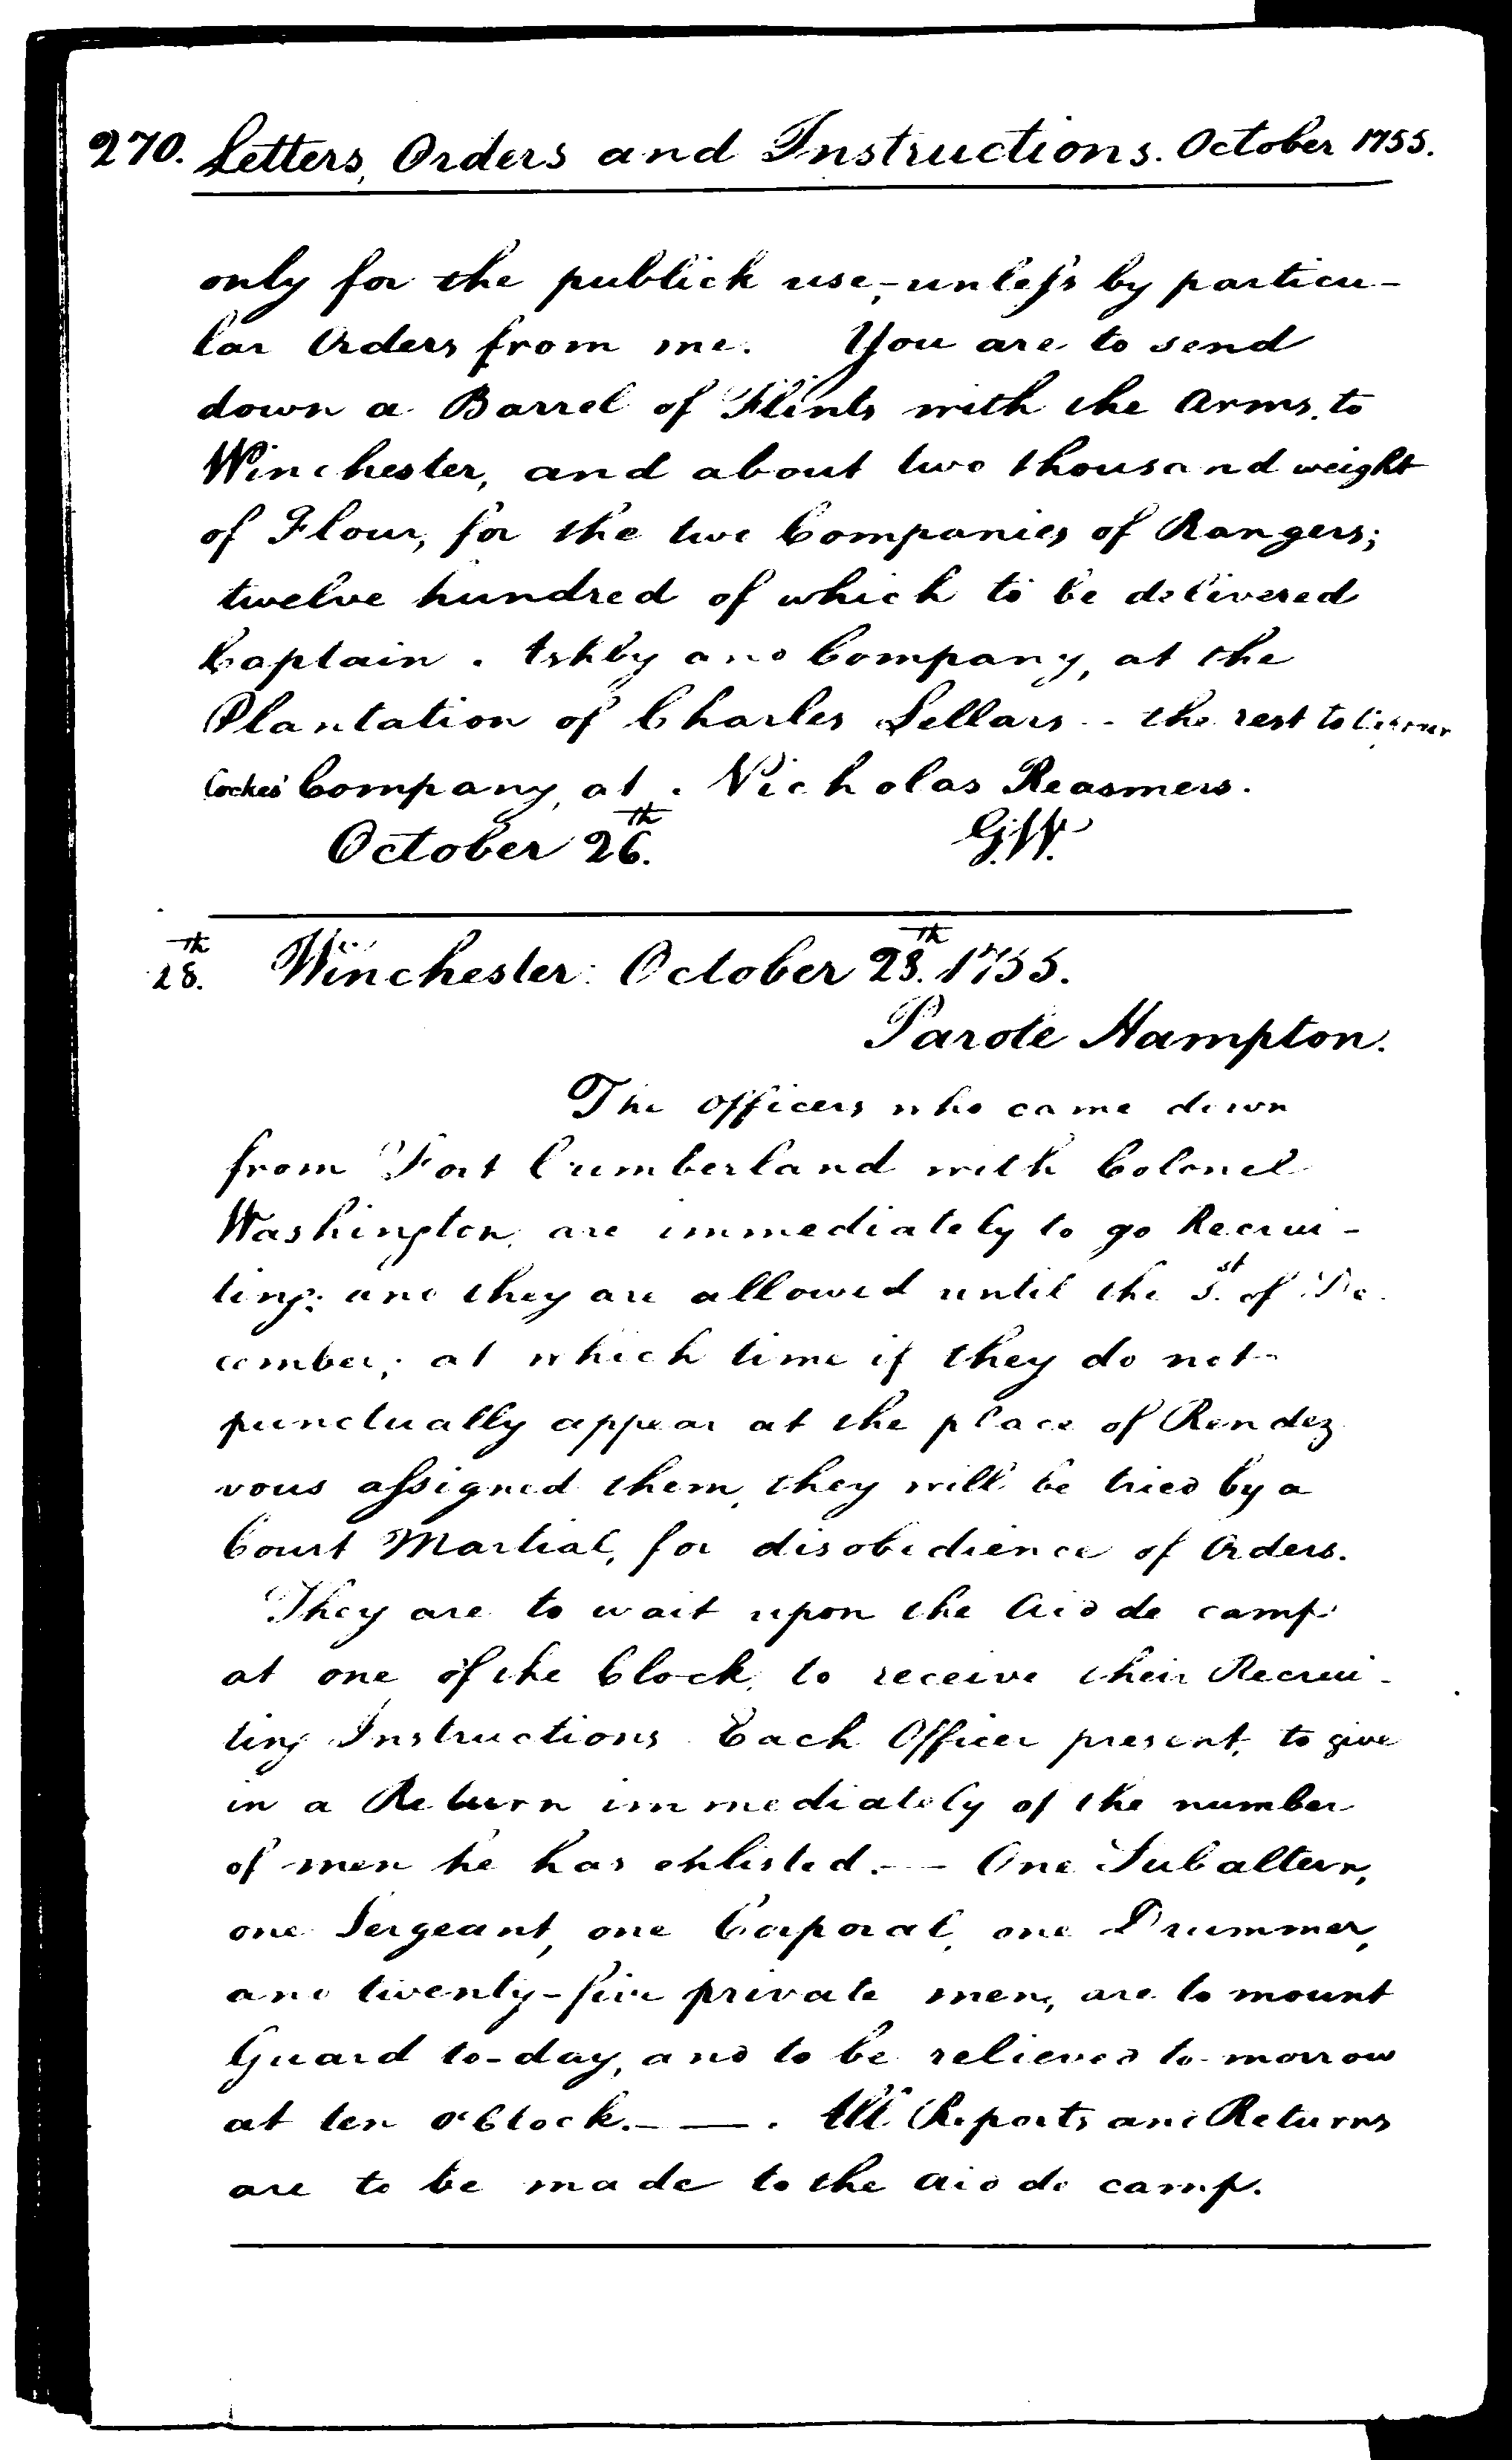

In [4]:
Image.fromarray(binarized_imgs["270.jpg"].astype('uint8')*255)

Now lets get the images from our "ground truth" SVGs:

In [5]:
try:
    with open("pickled/binarized_imgs", "rb") as f:
        words = pickle.load(f)

except FileNotFoundError:
    words = crop_images(binarized_imgs)

    with open("pickled/binarized_imgs", "wb") as f:
        pickle.dump(words, f)

FileNotFoundError: [Errno 2] No such file or directory: 'pickled/binarized_imgs'

Lets look at some words:

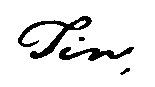

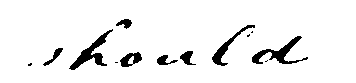

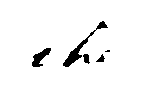

In [31]:
display(words["302.jpg"][13], words["271.jpg"][100], words["277.jpg"][60])

Mapping words to images can be done using the transcription.txt:

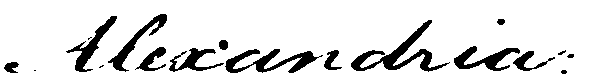

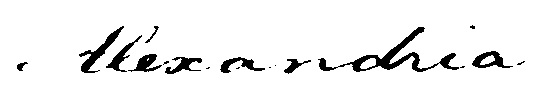

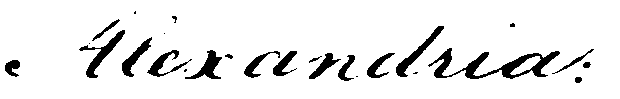

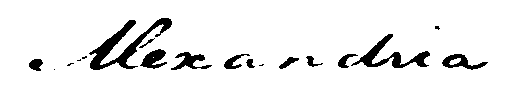

(100, 83) (100, 89) (100, 110)
x, y
45741.49193688466
z, y
61881.32934174797
z, x
74677.38475865117
t, y
62479.00928446738
t, z
65974.9654752416


In [32]:
display(*[words[k][i] for (k, i) in word_to_index("A-l-e-x-a-n-d-r-i-a")])

x, y = [words[k][i] for (k, i) in word_to_index("A-l-e-x-a-n-d-r-i-a")][:2]
x = np.array(x.resize((x.size[1], 100)))
y = np.array(y.resize((y.size[1], 100)))
z = [words[k][i] for (k, i) in word_to_index("o-n-l-y")][0]
z = np.array(z.resize((z.size[1], 100)))
t = [words[k][i] for (k, i) in word_to_index("c-o-m-p-t-s")][0]
t = np.array(t.resize((t.size[1], 100)))

print(x.shape, y.shape, z.shape)
print("x, y")
distance, path = fastdtw(x.T, y.T, dist=euclidean)
print(distance)

print("z, y")
distance, path = fastdtw(z.T, y.T, dist=euclidean)
print(distance)

print("z, x")
distance, path = fastdtw(z.T, x.T, dist=euclidean)
print(distance)

print("t, y")
distance, path = fastdtw(t.T, y.T, dist=euclidean)
print(distance)

print("t, z")
distance, path = fastdtw(t.T, z.T, dist=euclidean)
print(distance)

In [99]:
# let's get all keywords in a list
with open("task/keywords.txt", "r") as keywords_file:
    keywords_list = [remove_pt(line.strip()) for line in keywords_file]

keywords_list_helper = [x for x in keywords_list]

# get a list of images of the keywords (depending of the set we take the images from)
images_keywords_in_valid = []
for x in keywords_list_helper:
    images_keywords_helperv = [words[k][i] for (k, i) in word_to_index(x) if k.startswith("3")]
    if images_keywords_helperv == []:
        #print("valid:",x)
        keywords_list.remove(x)
    else:
        images_keywords_in_valid.append(images_keywords_helperv[0])

images_keywords_in_train = []
for x in keywords_list:
    images_keywords_helpert = [words[k][i] for (k, i) in word_to_index(x) if not k.startswith("3")]
    if images_keywords_helpert == []:
        print("train:", x)
    else:
        images_keywords_in_train.append(images_keywords_helpert[0])

# get a list of images form the train or valid set
with open("task/train.txt") as f:
    train = [l.strip() for l in f]
images_train_set = [i for (k, v) in words.items() for i in v if any(t for t in train if k.startswith(t))]
images_train = [(k,j) for (k, v) in words.items() for (j,i) in enumerate(v) if any(t for t in train if k.startswith(t))]
j = 0
images_train_index = []
for x in images_train:
    images_train_index.append((images_train[j], j))
    j = j + 1

with open("task/valid.txt") as f:
    valid = [l.strip() for l in f]
images_valid_set = [i for (k, v) in words.items() for i in v if any(t for t in valid if k.startswith(t))]
images_valid = [(k,j) for (k, v) in words.items() for (j,i) in enumerate(v) if any(t for t in valid if k.startswith(t))]
i = 0
images_valid_index = []
for x in images_valid:
    images_valid_index.append((images_valid[i], i))
    i = i + 1

In [101]:
# calculate for the images above the distance matrices with the train or valid set

images_keywords_in_valid = images_keywords_in_valid[0:2]


distMat_train_keywords = np.zeros((len(images_train_set), len(images_keywords_in_valid)))
i = 0
for x in images_keywords_in_valid:
    j = 0
    x = np.array(x.resize((x.size[1], 100)))
    for y in images_train_set:
        y = np.array(y.resize((y.size[1], 100)))
        distance, path = fastdtw(x.T, y.T, dist=euclidean)
        distMat_train_keywords[j][i] = distance
        j = j+1
    i= i+1

In [102]:
# calculate for the images above the distance matrices with the train or valid set

images_keywords_in_train = images_keywords_in_train[0:2]

distMat_valid_keywords = np.zeros((len(images_valid_set), len(images_keywords_in_train)))
i = 0
for x in images_keywords_in_train:
    j = 0
    x = np.array(x.resize((x.size[1], 100)))
    for y in images_valid_set:
        y = np.array(y.resize((y.size[1], 100)))
        distance, path = fastdtw(x.T, y.T, dist=euclidean)
        distMat_valid_keywords[j][i] = distance
        j = j+1
    i= i+1

In [106]:
# Evaluation of the Data

# For each image and each threshold (top-k matches), compute the TP, FP, FN
# Recall = TP / (TP + FN)
# Precision = TP / (TP + FP)
# Average Precision (AP): Area under the Recall-Precision curve

keywords_list = keywords_list[0:2]


# now we can start the evaluation
def evaluation(dist_train_keywords, dist_valid_keywords):
    tp_train = np.zeros((len(images_train_set), len(keywords_list)))
    fp_train = np.zeros((len(images_train_set), len(keywords_list)))
    fn_train = np.zeros((len(images_train_set), len(keywords_list)))
    precision_train = np.zeros((len(images_train_set), len(keywords_list)))
    recall_train = np.zeros((len(images_train_set), len(keywords_list)))

    tp_valid = np.zeros((len(images_valid_set), len(keywords_list)))
    fp_valid = np.zeros((len(images_valid_set), len(keywords_list)))
    fn_valid = np.zeros((len(images_valid_set), len(keywords_list)))
    precision_valid = np.zeros((len(images_valid_set), len(keywords_list)))
    recall_valid = np.zeros((len(images_valid_set), len(keywords_list)))

    # we start with the train set
    for keyword in keywords_list:
        index = 0
        # all ID's of the keyword in the train set
        keyword_ids = [(k, i) for (k, i) in word_to_index(keyword) if not k.startswith("3")]

        for k in range(len(images_train_set)):
            if k % 100 == 0:
                print("k =",k)
            # get the k smallest indices
            if(k == (len(images_train_set)-1)):
                idx = np.array([k for k in (range(k+1))])
            else:
                idx = np.argpartition(dist_train_keywords[:,index],k+1)[:(k+1)]
            # match the indices from the distMat with the images ID
            kmatches_ids = [x for (x, j) in images_train_index for i in idx if i==j]
            # adjust the fp, tp and fn
            for x in kmatches_ids:
                if x in keyword_ids:
                    tp_train[k,index] = tp_train[k,index]+1
                else:
                    fp_train[k,index] = fp_train[k,index]+1
            fn_train[k,index] = len(keyword_ids)-tp_train[k,index]

            precision_train[k,index] = tp_train[k,index]/(tp_train[k,index] + fp_train[k,index])
            recall_train[k,index] = tp_train[k,index]/(tp_train[k,index] + fn_train[k,index])
        
        index = index + 1


    # now the valid set
    for keyword in keywords_list:
        index = 0
        # all ID's of the keyword in the train set
        keyword_ids = [(k, i) for (k, i) in word_to_index(keyword) if k.startswith("3")]

        for k in range(len(images_valid_set)):
            if k % 100 == 0:
                print("k =",k)
            # get the k smallest indices
            if(k == (len(images_valid_set)-1)):
                idx = np.array([k for k in (range(k+1))])
            else:
                idx = np.argpartition(dist_valid_keywords[:,index],k+1)[:(k+1)]
            # match the indices from the distMat with the images ID
            kmatches_ids = [x for (x, j) in images_valid_index for i in idx if i==j]
            # adjust the fp, tp and fn
            for x in kmatches_ids:
                if x in keyword_ids:
                    tp_valid[k,index] = tp_valid[k,index]+1
                else:
                    fp_valid[k,index] = fp_valid[k,index]+1
            fn_valid[k,index] = len(keyword_ids)-tp_valid[k,index]

            precision_valid[k,index] = tp_valid[k,index]/(tp_valid[k,index] + fp_valid[k,index])
            recall_valid[k,index] = tp_valid[k,index]/(tp_valid[k,index] + fn_valid[k,index])
    
        index = index + 1

    return precision_train, recall_train, precision_valid, recall_valid


In [ ]:
print(len(images_train_set))
print(len(images_valid_set))

In [107]:
precision_t, recall_t, precision_v, recall_v = evaluation(distMat_train_keywords, distMat_valid_keywords)

print(precision_t)

k = 0
k = 100
k = 200
k = 300
k = 400
k = 500
k = 600
k = 700
k = 800
k = 900
k = 1000
k = 1100
k = 1200
k = 1300
k = 1400
k = 1500
k = 1600
k = 1700
k = 1800
k = 1900
k = 2000
k = 2100
k = 2200
k = 2300
k = 2400
k = 0
k = 100
k = 200
k = 300
k = 400
k = 500
k = 600
k = 700
k = 800
k = 900
k = 1000
k = 1100
k = 1200
k = 1300
k = 1400
k = 1500
k = 1600
k = 1700
k = 1800
k = 1900


In [104]:
plt.plot(recall_t[:,0],precision_t[:,0])
plt.plot(recall_v[:,0],precision_v[:,0])
plt.legend(['First Image in Train', 'First Image in Validation'], loc='upper right')
plt.xlabel('Recall')
plt.ylabel('Precision')
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])
plt.show

KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

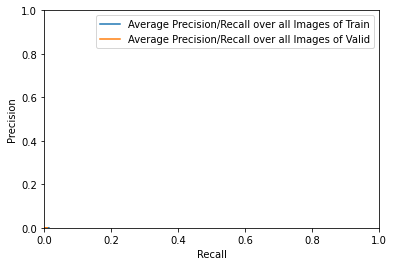

In [96]:
precision_t_a = [x/len(np.sum(precision_t,axis=1).tolist()) for x in np.sum(precision_t,axis=1).tolist()]
recall_t_a = [x/len(np.sum(recall_t,axis=1).tolist()) for x in np.sum(recall_t,axis=1).tolist()]
precision_v_a = [x/len(np.sum(precision_v,axis=1).tolist()) for x in np.sum(precision_v,axis=1).tolist()]
recall_v_a = [x/len(np.sum(recall_v,axis=1).tolist()) for x in np.sum(recall_v,axis=1).tolist()]

plt.plot(recall_t_a,precision_t_a)
plt.plot(recall_v_a,precision_v_a)
plt.legend(['Average Precision/Recall over all Images of Train', 'Average Precision/Recall over all Images of Valid'], loc='upper right')
plt.xlabel('Recall')
plt.ylabel('Precision')
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])
plt.show